<a href="https://colab.research.google.com/github/CamachoTech/analise_exploratoria_de_dados/blob/main/analise_exploratoria_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

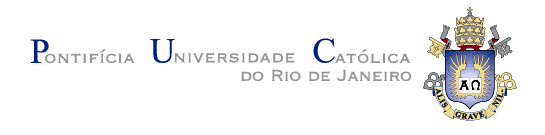

# MVP - Análise exploratória de dados e boas práticas

Euclides Camacho de Souza

### 1. Definição do Problema
Este MVP tem por objetivo prever a quantidade de bicicletas compartilhas serão utilizadas em um determinado dia em Washington D.C., utilizando um algorítmo de aprendizado de máquina supervisionado (quando sabemos entrada e saída). Para isso, um dataset parecido com o [UCI Bike Sharing Dataset](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset) foi montado, extraindo dados sobre o aluguel de bicicletas do site [Capital Bike](http://capitalbikeshare.com/system-data), e informações sobre o clima, visto que influencia no ato de alugar ou não, do site [freemeteo](http://www.freemeteo.com).

Vale ressaltar que os dados do UCI citado anteriormente, já estão na forma numérica, por esse motivo decidir extrair os dados das mesmas fontes e montar um dataset menos tratado, com o objetivo de aplicar os tratamentos aprendidos neste curso.




In [1]:
# Imports

# Pacotes para tratamento de dados
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer

 # para normalização
from sklearn.preprocessing import MinMaxScaler

## Transformações Categóricas
from sklearn.preprocessing import OneHotEncoder

## modelo de treino
from sklearn.model_selection import train_test_split

# para tratamento de missings
import missingno as ms

import sys
import os

# Conectando e montando o caminha do drive
from google.colab import drive
drive.mount(r'/content/drive', force_remount=True)

# Construção de gráficos
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Exibição de dados no jupyter notebook
from IPython.display import display

# # Pacote para identificação da cidade com a Longitude e Latitude
# from geopy.geocoders import Nominatim

# # Inciando Nominatim API
# geolocator = Nominatim(user_agent='geopy/2.4.1')

# # Como temos muitas linhas, alteramos o tempo de delay
# from geopy.extra.rate_limiter import RateLimiter
# geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

Mounted at /content/drive


In [2]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")


### 2. Montagem do Dataset

O dataset final terá as seguintes informações:
- data
- estacao_ano : verão, inverno, primavera e outono
- ano: 2021 e 2022
- mes: meses do ano de 1 a 12
- feriado: se a data é feriado (True ou False)
- dia_util: se não for feriado ou final de semana (True ou False)

- descricao_clima: Chuva,
  - Neve,
  - Neve Chuva,
  - Nevoeiro Neve,
  - Nevoeiro Chuva,
  - Tempestade de raios Chuva,
  - Nevoeiro Tempestade de raios Chuva,
  - Nevoeiro Neve Chuva
  - Parcialmente nublado ou poucas nuvens
  - Nublado e raios
  - Nublado e sincelo

- temp_min_C: temperatura mínima do dia em °C
- temp_min_max: temperatura máxima do dia em °C
- vento_constante_km_h: velocidade do vento constante em km/h
- rajda_vento_km_h: rajada de vento em km/h
- volume_chuva:volume de chuva em mm
- espessura_neve: espessura de neve em mm

- qtd_casual: quantidade de usuários casuais
- qtd_registrado: quantidade de usuários registrados
- qtd_total: quantidade de usuários totais



#### 2.1. Dados sobre as locações
Para chegar nos dados sobre aluguéis das bicicletas, foram realizados downloads de 24 pastas e unificados os arquivos csv com o código na célula seguinte, mas para não correr o risco de tratar o MVP, unificamos com o pandas.concat e salvamos no drive. Com isso, será uma consulta simples ao arquivo unificado com os dados de janeiro de 2021 até 31 de dezembro de 2022.


In [3]:
# Lendo todos os arquivos e unificando os dados
'''
part_1 = r'/content/drive/MyDrive/MVP/capital_bike_share/'
df = pd.read_csv(part_1 + 'capital_bike_share_unificado.csv')
'''

## Deletar as linhas que tenham alguma coorde-
## nada vazia/nula (NaN), pois não consiguimos
## identificar sua localização
'''
df = df.dropna(how='any')
df.reset_index(drop=True, inplace=True)
'''

# Criando a coluna data para cruzamento com as informações
## metereológicas
'''
df['started_at'] = df['started_at'].str[0:10]
'''
print('')

Agrupando a quantidade de usuários por dia para saber a quantidade de usuários casuais, registrados e totais.

In [4]:
# Selecionando parte do dataframe par contagem
'''
capital_bike_share = df[['started_at','ride_id','member_casual']]
'''
# Agrupando com groupby.agg para realizar a contagem
## de uma única vez
'''
capital_bike_share = capital_bike_share.pivot_table(values='ride_id',
        index='started_at', columns='member_casual', aggfunc='count')\
                                               .reset_index(drop=False)
'''
# Selecionando as colunas necessárias
'''
capital_bike_share = capital_bike_share[['started_at','casual','member']]
'''
# Renomeando as colunas
'''
capital_bike_share.columns = ['data','qtd_casual','qtd_registrado']
'''
# Total de aluguies
'''
capital_bike_share['qtd_total'] = capital_bike_share['qtd_casual'] + \
                                  capital_bike_share['qtd_registrado']
'''
print('')

Devido ao tamanho do arquivo com os dados diários distribuídos ao longo do dia, iremos carregar o dataset com os dados de quantidade de aluguéis de bicicleta por dia, diretamos do GitHub (que **suporta arquivos com no máximo 25MB**, e o arquivo **original tem 1,2GB**).

In [5]:
capital_bike_share = \
  pd.read_csv(r'https://raw.githubusercontent.com/CamachoTech/analise_exploratoria_de_dados/main/bike_share_tratado.csv')

#### 2.2. Dados metereológicos

Os dados sobre a condição climática foram extraídos através de WebScraping, capturando as tabelas em formatos HTML e trasnformando para Pandas DataFrame. Da tabela capturada utilizaremos a data, temperaturas mínimas e máximas, velocidade do vento (e a velocidade máxima ou rajada de vento), volume de chuva, espessura da nece e a descrição do clima (chuva, neve, nublado, tempestade ...)

In [6]:
# Requisanto os dados e transformando em Pandas DataFrame
'''
for year in [2021, 2022]:
  for mes in range(1,13):
    url = 'https://freemeteo.com.br/clima/washington/historico/historico-por-mes/?gid=4140963&station=19064&month={}&year={}&language=portuguesebr&country=us-united-states'\
                    .format(mes,year)
    res = requests.get(url)

    noStarchSoup = BeautifulSoup(res.text, 'html.parser')

    table = noStarchSoup.select('#monthly-archive > div.today.table > div > table')

    if year==2021 and mes==1:
      df_clima_tempo_dia = pd.read_html(str(table))[0]
    else:
      df_clima_tempo_dia = pd.concat([df_clima_tempo_dia,
                              pd.read_html(str(table))[0]])
'''
# Salvando em csv para o teste do MVP (para evitar travamento)
'''
df_clima_tempo_dia.to_csv('df_clima_tempo_por_dia_hora.csv',index=False)
'''
print('')

In [7]:
# Lendo os dados metereológicos de Washington D.C
clima_tempo = \
  pd.read_csv('https://raw.githubusercontent.com/CamachoTech/analise_exploratoria_de_dados/main/df_clima_tempo_mensal_diario.csv')

# Selecionando as colunas necessárias sobre o clima
clima_tempo = clima_tempo[[
      'Data', 'Temperatura mínima diária', 'Temperatura máxima diária',
       'Vento constante máximo', 'Rajada de vento máxima',
       'Precipitação diária total', 'Espessura de neve', 'Descrição']]

# Renomeando as colunas
clima_tempo.columns = ['data', 'temp_min_C','temp_max_C','vento_constante_km_h',
                       'rajada_vento_km_h','volume_chuva','espessura_neve',
                       'descricao_clima']

# Padronizando a coluna data
clima_tempo['data']  = clima_tempo['data'].str[6::] + '-'+ \
                               clima_tempo['data'].str[3:5]\
                          +'-'+ clima_tempo['data'].str[0:2]

Identificando a estação climática

In [8]:
# Identificando a estação do ano identificados pelo mês,
## mas para uma maior precisa
# Verão
condicao = clima_tempo['data'].str[5:7]\
          .isin(['06', '07', '08'])
clima_tempo.loc[condicao,'estacao_ano']='verão'

# Outono
condicao = clima_tempo['data'].str[5:7]\
          .isin(['09', '10', '11'])
clima_tempo.loc[condicao,'estacao_ano']='outono'

# Inverno
condicao = clima_tempo['data'].str[5:7]\
          .isin(['12', '01', '02'])
clima_tempo.loc[condicao,'estacao_ano']='inverno'

# Primavera
condicao = clima_tempo['data'].str[5:7]\
          .isin(['03', '04', '05'])
clima_tempo.loc[condicao,'estacao_ano']='primavera'

#### 2.3. Cruzando as informações de aluguéis e metereológicas
(unificando os dados em um único pandas dataframe)

In [9]:
# Faremos inner, pois queremos saber a condição climática
capital_bike_share = pd.merge(
                              capital_bike_share,
                              clima_tempo,
                              how='inner',
                              on='data'
)

#### 2.4 Cirando as colunas ano, mes, feriado e dia_util
Os feriados foram extraídos do site [dchr.dc.gov](https://dchr.dc.gov/page/holiday-schedules)

In [10]:
'10-09' in capital_bike_share['data'].str[5::].tolist()

True

In [11]:
# Coluna ano
capital_bike_share['ano'] = capital_bike_share['data'].str[0:4]

# Coluna mes
capital_bike_share['mes'] = capital_bike_share['data'].str[5:7]

# Feriado em Washington D.C
feriados = ['01-02','01-16','02-16', '02-20','04-17','05-29',
                '06-19','07-04','09-04','10-09','11-23','25']

capital_bike_share.loc[:, 'feriado']= False
condicao = capital_bike_share['data'].str[5::].isin(feriados)
capital_bike_share.loc[condicao, 'feriado']= True

# Dia útil
capital_bike_share.loc[:, 'dia_util'] = True

condicao_1 = capital_bike_share['data']\
                  .astype('datetime64[ns]')\
                  .dt.weekday>=6

condicao_2 = capital_bike_share['feriado'] == True

condicao = condicao_1 | condicao_2

capital_bike_share.loc[condicao, 'dia_util'] = False

Reordenando as colunas

In [12]:
capital_bike_share = capital_bike_share[[
          'data','ano','mes', 'feriado','dia_util',
          'descricao_clima','temp_min_C', 'temp_max_C',
           'vento_constante_km_h','rajada_vento_km_h',
          'volume_chuva','espessura_neve','estacao_ano'
          ,'qtd_casual','qtd_registrado','qtd_total']]

#### 2.5 Transformando colunas em tipos numéricos
Iremos transforma as colunas com informações sobre temperatura, velocidade do vento e espessura da neve em dados numpericos para facitar a visualização nos gráficos das análises exploratórias


In [13]:
# Dados de temperatura para  tipo numérico
capital_bike_share['temp_min_C'] = capital_bike_share['temp_min_C']\
                                              .str.replace('°C','')\
                                                      .astype(float)

capital_bike_share['temp_max_C'] = capital_bike_share['temp_max_C']\
                                              .str.replace('°C','')\
                                                      .astype(float)


# Transformando as informações sobre velocidade do vento
capital_bike_share['vento_constante_km_h'] = \
                          capital_bike_share['vento_constante_km_h']\
                                            .str.replace(' Km/h','')\
                                                        .astype(float)
capital_bike_share['rajada_vento_km_h'] = \
                            capital_bike_share['rajada_vento_km_h']\
                                            .str.replace(' Km/h','')\
                                                        .astype(float)

# Transformando as colunas espessura_neve e volume_chuva
capital_bike_share['espessura_neve'] = \
                              capital_bike_share['espessura_neve']\
                                             .str.replace(',','.')\
                              .str.replace('mm|cm|m','',regex=True)\
                                                     .astype(float)
capital_bike_share['volume_chuva'] = \
                            capital_bike_share['volume_chuva']\
                            .str.replace(',','.')\
                            .str.replace('mm','',regex=True)\
                                               .astype(float)

#### 2.6 Identificação dos eventos climáticos para os casos não identificados
Os dados capturados sobre o clima de um determinado dia tem mais de 500 casos classifcados como "eventos climáticos não informados", para resolver esse problema foi realizado mais um webScraping, mas desse vez na tabela com informções sobre a condicação climática ao longo do dia, para o príodo de 2021-01-01 até 2022-12-31.

In [14]:
# Dias que serão capturados o clima
'''
periodo = pd.date_range(start='2021-01-01', end='2022-12-31',freq='D')
'''
# Requisanto os dados e transformando em Pandas DataFrame
'''
for year_month_day in periodo:
  url = 'https://freemeteo.com.br/clima/washington/historico/historico-por-dia/?gid=4140963&station=19064&date={}&language=portuguesebr&country=us-united-states'\
                  .format(year_month_day.strftime('%Y-%m-%d'))
  res = requests.get(url)

  noStarchSoup = BeautifulSoup(res.text, 'html.parser')

  table = noStarchSoup.select('#content > div.right-col > div.weather-now > div.today.table > div > table')

  if year_month_day.strftime('%Y-%m-%d')=='2021-01-01':
    df_clima_tempo_por_dia_hora = pd.read_html(str(table))[0]
    df_clima_tempo_por_dia_hora['dia'] = '2021-01-01'
  else:
    print(year_month_day.strftime('%Y-%m-%d'))
    temp = pd.read_html(str(table))[0]
    temp['dia'] = year_month_day.strftime('%Y-%m-%d')

    df_clima_tempo_por_dia_hora = pd.concat([
                                df_clima_tempo_por_dia_hora,
                                                     temp])
'''
# Salvando em csv para o teste do MVP (para evitar travamento)
'''
df_clima_tempo_por_dia_hora.to_csv('df_clima_tempo_por_dia_hora.csv',index=False)
'''
print('')

In [15]:
# Carregando arquivo csv com os eventos climáticos ao longo do dia
clima_tempo_dia_hora = \
  pd.read_csv('https://raw.githubusercontent.com/CamachoTech/analise_exploratoria_de_dados/main/df_clima_tempo_por_dia_hora.csv')

Identificação do evento climático de acordo com o código

In [16]:
condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(1',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Limpo'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(2',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Poucas nuvens'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(3',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Parcialemente nublado'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(4',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Nublado'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(7',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(8',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva forte'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(10',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Trovão'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(26',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Neve'

condicao = clima_tempo_dia_hora.DescriçãoDetalhes.str.contains('\(94',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Sincelo'

Agrupando todos os eventos climáticos por dia

In [17]:
# Selecionando as colunas necessárias
clima_tempo_dia_hora = clima_tempo_dia_hora[['dia','descricao_detalhes']]

# Retirando as duplicidades de eventos no mesmo dia
clima_tempo_dia_hora.drop_duplicates(inplace=True)

# Ordenando pelo evento climático
clima_tempo_dia_hora.sort_values(by='descricao_detalhes', inplace = True)

In [18]:
# Agrupando os eventos climáticos identifcados no dia
clima_tempo_dia_hora['descricao_detalhes'] = clima_tempo_dia_hora.groupby(['dia'])\
                          ['descricao_detalhes'].transform(lambda x: ', '.join(x))

# Retirandos as linhas duplicados
clima_tempo_dia_hora.drop_duplicates(inplace = True)

A seguir iremos classificar os eventos climáticos com os seguintes tipos:
 - Chuva,
 - Neve,
 - Neve Chuva,
 - Nevoeiro Neve,
 - Nevoeiro Chuva,
 - Tempestade de raios Chuva,
 - Nevoeiro Tempestade de raios Chuva,
 - Nevoeiro Neve Chuva
 - Parcialmente nublado ou poucas nuvens
 - Nublado e raios
 - Nublado e sincelo

Para isso, visualizei os agrupamentos possíveis e fui classificando de acordo com as combinações dos eventos climáticos

In [19]:
condicao = clima_tempo_dia_hora.descricao_detalhes.str.contains('Chuva, Nublado, Parcialemente nublado, Poucas nuvens',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
  .contains('Chuva, Nublado, Parcialemente nublado, Poucas nuvens, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
              .contains('Chuva, Nublado, Parcialemente nublado',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'



condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Nublado, Parcialemente nublado, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'



condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Nublado, Parcialemente nublado, Poucas nuvens',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'



condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Nublado, Parcialemente nublado, Poucas nuvens, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Parcialemente nublado, Poucas nuvens, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Parcialemente nublado, Poucas nuvens, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes.str.contains('Chuva, Nublado',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str.contains('Chuva, Nublado, Trovão',na=False)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Nublado, Trovão|Chuva, Limpo, Parcialemente nublado, Poucas nuvens, Trovão',
                                                                          na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Tempestade de raios Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Nublado, Poucas nuvens|Chuva, Limpo, Nublado, Parcialemente nublado|Chuva, Limpo, Nublado',
                                                                                    na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Neve, Nublado, Parcialemente nublado, Poucas nuvens',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Neve, Nublado, Parcialemente nublado, Poucas nuvens',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Neve Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Neve, Nublado, Parcialemente nublado, Poucas nuvens|Chuva, Neve, Nublado, Poucas nuvens|Chuva, Neve, Nublado, Parcialemente nublado|Chuva, Limpo, Neve, Nublado|Chuva, Neve, Nublado, Parcialemente nublado, Poucas nuvens|Chuva, Neve, Nublado',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Neve Chuva'


condicao = clima_tempo_dia_hora.descricao_detalhes=='Limpo'
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Limpo'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Chuva, Limpo, Neve, Nublado, Parcialemente nublado, Poucas nuvens',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Neve Chuva'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Limpo, Nublado, Parcialemente nublado, Poucas nuvens|Limpo, Parcialemente nublado, Poucas nuvens|Limpo, Poucas nuvensLimpo, Nublado, Parcialemente nublado|Limpo, Nublado, Poucas nuvens|Nublado, Parcialemente nublado, Poucas nuvens|Parcialemente nublado, Poucas nuvens'
,na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Parcialmente nublado ou poucas nuvens'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Poucas nuvens|Limpo, Parcialemente nublado, Poucas nuvens',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Poucas nuvens'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Nublado',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Nublado'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Limpo, Parcialemente nublado, Poucas nuvens, Trovão|Limpo, Nublado, Parcialemente nublado, Poucas nuvens, Trovão|Limpo, Parcialemente nublado, Poucas nuvens, Trovão|Nublado, Parcialemente nublado, Trovão',
                                                                  na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Nublado e raios'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Nublado',na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Nublado'

condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Limpo, Neve, Nublado, Parcialemente nublado, Poucas nuvens|Neve, Nublado, Parcialemente nublado, Poucas nuvens|Neve, Nublado',
                                                                                                                  na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Neve'


condicao = clima_tempo_dia_hora.descricao_detalhes.str\
.contains('Limpo, Nublado, Parcialemente nublado, Poucas nuvens, Sincelo', na=False,regex=True)
clima_tempo_dia_hora.loc[condicao, 'descricao_detalhes'] = 'Nublado e sincelo'


 Substituindo as informações de "eventos climáticos não informados" pela identificação realizada anteriormente no dataFrame capital_bike_share

In [20]:
# Renomenado as colunas para crazemento com o dataFrame clima_tempo
clima_tempo_dia_hora.columns = ['data', 'descricaoDetalhes']

# Crauzando as tabelas com os dados metereológicos
capital_bike_share = pd.merge(
              capital_bike_share,
              clima_tempo_dia_hora,
              how='left',
              on='data'
)

condicao = capital_bike_share.descricao_clima == 'eventos climáticos não informados'

capital_bike_share.loc[condicao, 'descricao_clima'] = \
                            capital_bike_share.loc[condicao, 'descricaoDetalhes']

# Retirando a coluna 'descricaoDetalhes
capital_bike_share = capital_bike_share[[
                            'data','ano','mes', 'feriado','dia_util',
                        'descricao_clima','temp_min_C', 'temp_max_C',
                          'vento_constante_km_h','rajada_vento_km_h',
                          'volume_chuva','espessura_neve','estacao_ano'
                          ,'qtd_casual','qtd_registrado','qtd_total']]

### 3. Análise dos dados

#### 3.1 Estatísticas descritivas

In [21]:
# Dimensões do dataset
capital_bike_share.shape

(727, 16)

Nosso dataset tem 727 instancias e 15 características

In [22]:
# Informaçoes sobre as colunas, tipo dos dados e nulos
capital_bike_share.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 0 to 726
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   data                  727 non-null    object 
 1   ano                   727 non-null    object 
 2   mes                   727 non-null    object 
 3   feriado               727 non-null    bool   
 4   dia_util              727 non-null    bool   
 5   descricao_clima       727 non-null    object 
 6   temp_min_C            726 non-null    float64
 7   temp_max_C            726 non-null    float64
 8   vento_constante_km_h  671 non-null    float64
 9   rajada_vento_km_h     227 non-null    float64
 10  volume_chuva          723 non-null    float64
 11  espessura_neve        13 non-null     float64
 12  estacao_ano           727 non-null    object 
 13  qtd_casual            727 non-null    int64  
 14  qtd_registrado        727 non-null    int64  
 15  qtd_total             7

Podemos perceber que as colunas **vento_constante_km_h**, **rajada_vento_km_h**, **espessura_neve**, **volume_chuva**, tem valores nulos que precisamos tratar com dados estatísticos para melhorar a qualidade da base de dados.

In [23]:
# Visualização as 10 primeiras linhas do dataset
capital_bike_share.head(10)

,data,ano,mes,feriado,dia_util,descricao_clima,temp_min_C,temp_max_C,vento_constante_km_h,rajada_vento_km_h,volume_chuva,espessura_neve,estacao_ano,qtd_casual,qtd_registrado,qtd_total
0,2021-01-01,2021,01,False,True,Chuva,2.0,6.0,24.0,NaN,11.6,NaN,inverno,258,516,774
1,2021-01-02,2021,01,True,False,Chuva,2.0,14.0,28.0,42.0,20.5,NaN,inverno,2568,2562,5130
2,2021-01-03,2021,01,False,False,Chuva,3.0,14.0,21.0,NaN,4.8,NaN,inverno,373,926,1299
3,2021-01-04,2021,01,False,True,Parcialmente nublado ou poucas nuvens,1.0,8.0,NaN,NaN,2.2,NaN,inverno,716,1809,2525
4,2021-01-05,2021,01,False,True,Chuva,1.0,8.0,24.0,NaN,0.0,NaN,inverno,859,1693,2552
5,2021-01-06,2021,01,False,True,Nublado,4.0,7.0,35.0,48.0,0.7,NaN,inverno,1108,1520,2628
6,2021-01-07,2021,01,False,True,Parcialmente nublado ou poucas nuvens,1.0,8.0,32.0,52.0,0.0,NaN,inverno,970,1870,2840
7,2021-01-08,2021,01,False,True,Parcialmente nublado ou poucas nuvens,2.0,5.0,21.0,NaN,0.0,NaN,inverno,591,1897,2488
8,2021-01-09,2021,01,False,True,Parcialmente nublado ou poucas nuvens,1.0,2.0,24.0,NaN,0.0,NaN,inverno,1228,2272,3500
9,2021-01-10,2021,01,False,False,Poucas nuvens,4.0,5.0,26.0,48.0,0.0,NaN,inverno,1238,2262,3500


In [24]:
# Mostra as 10 últimas linhas do dataset
capital_bike_share.tail(10)

,data,ano,mes,feriado,dia_util,descricao_clima,temp_min_C,temp_max_C,vento_constante_km_h,rajada_vento_km_h,volume_chuva,espessura_neve,estacao_ano,qtd_casual,qtd_registrado,qtd_total
717,2022-12-20,2022,12,False,True,Parcialmente nublado ou poucas nuvens,-1.0,1.0,21.0,41.0,0.0,NaN,inverno,1389,3859,5248
718,2022-12-21,2022,12,False,True,Parcialmente nublado ou poucas nuvens,-2.0,8.0,NaN,NaN,0.0,NaN,inverno,1444,3573,5017
719,2022-12-22,2022,12,False,True,Neve Chuva,1.0,3.0,13.0,NaN,0.0,NaN,inverno,276,1118,1394
720,2022-12-23,2022,12,False,True,Chuva,8.0,13.0,26.0,46.0,29.4,NaN,inverno,370,1098,1468
721,2022-12-24,2022,12,False,True,Poucas nuvens,-12.0,-9.0,28.0,41.0,2.7,NaN,inverno,252,678,930
722,2022-12-25,2022,12,False,False,Poucas nuvens,-9.0,-8.0,15.0,NaN,0.0,NaN,inverno,338,456,794
723,2022-12-26,2022,12,False,True,Parcialmente nublado ou poucas nuvens,-10.0,1.0,15.0,NaN,0.0,NaN,inverno,543,1081,1624
724,2022-12-27,2022,12,False,True,Parcialmente nublado ou poucas nuvens,-1.0,0.0,8.0,NaN,0.0,NaN,inverno,1135,2072,3207
725,2022-12-28,2022,12,False,True,Parcialmente nublado ou poucas nuvens,-2.0,2.0,5.0,NaN,0.0,NaN,inverno,1745,2462,4207
726,2022-12-29,2022,12,False,True,Parcialmente nublado ou poucas nuvens,1.0,3.0,11.0,NaN,0.0,NaN,inverno,2315,2895,5210


Resumo dos dados estatísticos do dataset (média, desvio padrão, mínimo, máximo e os quartis)

In [25]:
# resumo estatístico
capital_bike_share.describe()

,temp_min_C,temp_max_C,vento_constante_km_h,rajada_vento_km_h,volume_chuva,espessura_neve,qtd_casual,qtd_registrado,qtd_total
count,726.000000,726.000000,671.000000,227.000000,723.000000,13.000000,727.000000,727.000000,727.000000
mean,12.002755,17.041322,20.065574,46.405286,3.033057,5.376923,3159.987620,4671.023384,7831.011004
std,9.178986,9.550357,9.624992,12.334697,8.557158,4.668717,1972.025445,1831.218428,3466.056771
min,-12.000000,-9.000000,5.000000,28.000000,0.000000,3.000000,124.000000,293.000000,417.000000
25%,4.000000,9.000000,13.000000,37.000000,0.000000,3.000000,1586.500000,3362.000000,5082.500000
50%,12.000000,18.000000,16.000000,45.000000,0.000000,3.000000,2866.000000,4781.000000,7850.000000
75%,21.000000,25.000000,26.000000,52.000000,0.700000,5.000000,4496.000000,6120.500000,10588.500000
max,28.000000,36.000000,65.000000,92.000000,102.800000,18.000000,12246.000000,9072.000000,18446.000000


Podemos perceber que o data que mais chama atenção é o **desvio padrão da quantidade total de vezes que as bicicletas foram alugadas** em um determinado dia, pois o número está **proximo de 3500**, evidenciando que algum fator climático está influênciando as pessoas passearem de bicicletas ou não.

#### 3.2  Visualizações Unimodais

Com a visulização destes dados no formato de histogramas está **difícil classifcar a distribuiçao em normal ou não**.

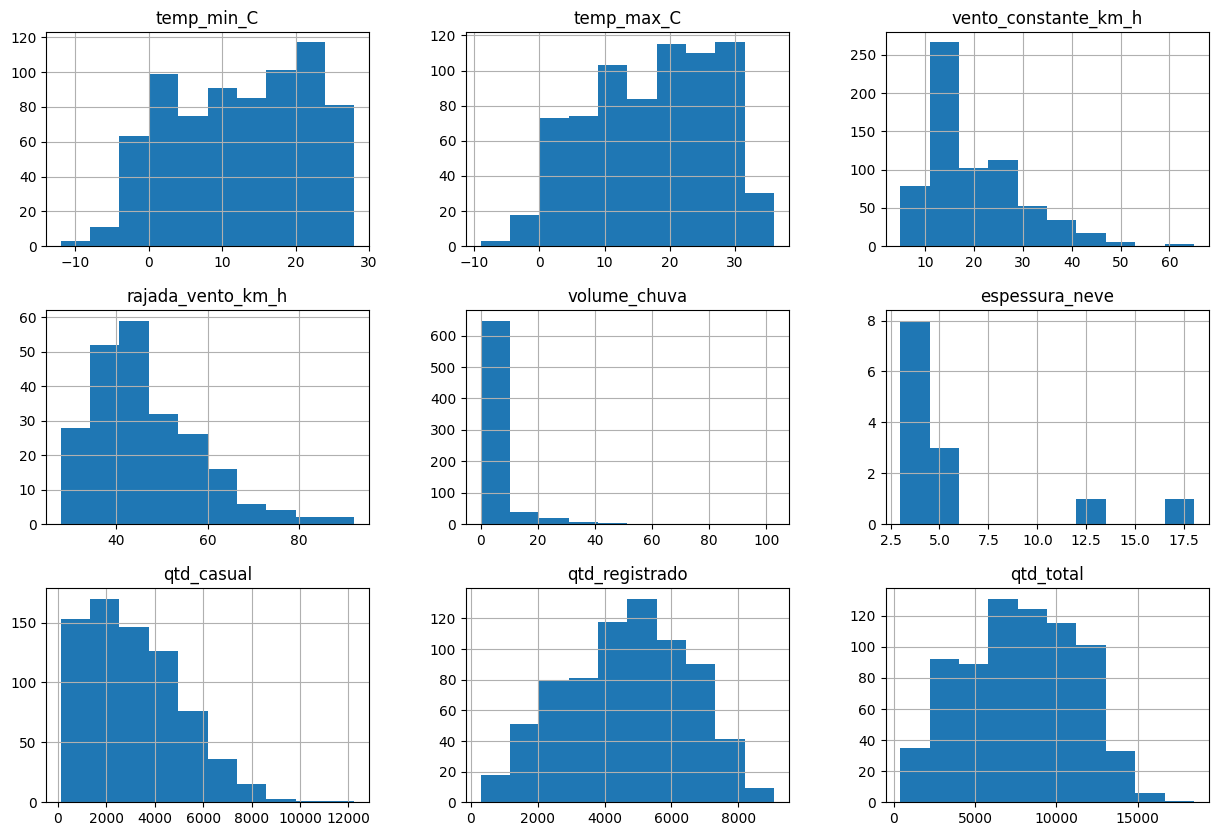

In [26]:
capital_bike_share.hist(figsize=(15,10))
plt.show()

Com os gráficos de densidade a seguir, exceto a coluna **volume_chuva não parece ser uma distribuiçao aproximadamente normal**

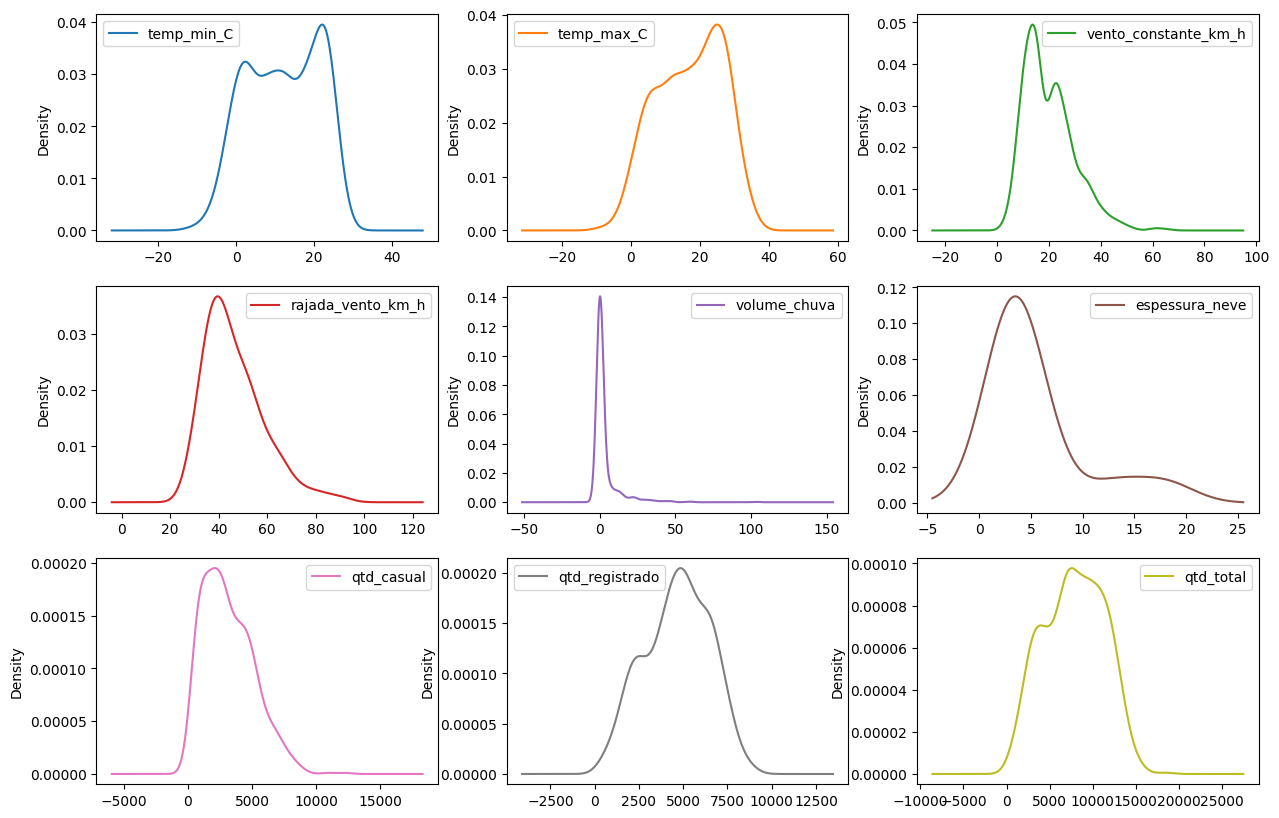

In [27]:
# Density Plot
capital_bike_share.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (15,10))
plt.show()

Para termos uma melhor visualização com **trasnformação Box-Cox**, podemos perceber que todos os dados numéricos são aproximadamente uma distribuição normal

In [28]:
# Tipo de transformação
power = PowerTransformer(method='box-cox', standardize=True)

# Seleciona e transforma dados diferente de 'object' e 'bool'
for coluna in capital_bike_share.select_dtypes(exclude=['object',bool]).columns:
  if coluna == capital_bike_share.select_dtypes(exclude=['object',bool]).columns[0]:
    a = power.fit_transform(capital_bike_share['vento_constante_km_h'].to_numpy().reshape(-1,1))
    df_transform = pd.DataFrame(a, columns=[coluna])
  else:
    a = power.fit_transform(capital_bike_share['vento_constante_km_h'].to_numpy().reshape(-1,1))
    df_transform_pre = pd.DataFrame(a, columns=[coluna])
    df_transform = pd.concat([df_transform, df_transform_pre])

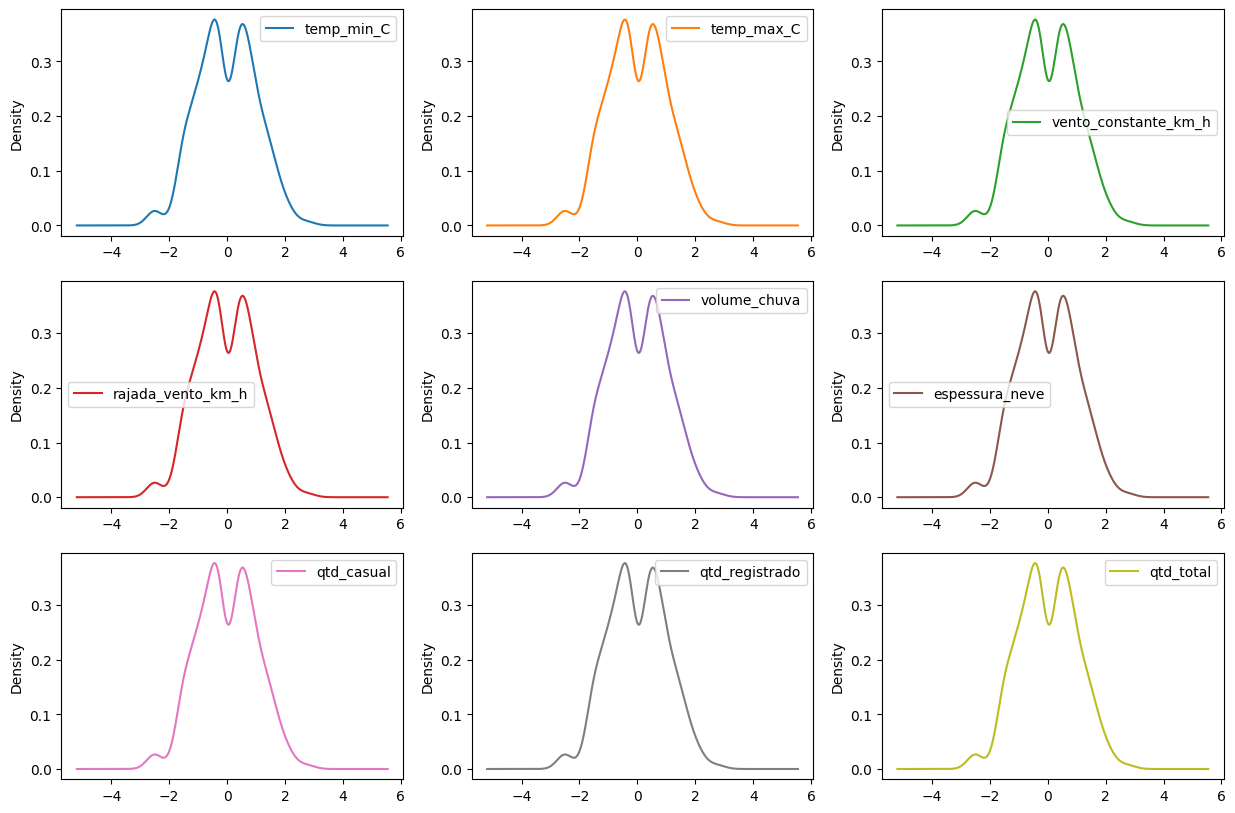

In [29]:
df_transform.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (15,10));
print('')

Para ter uma visão dos **outliers** o boxplot é um dos gráficos mais utilizadas, visto que separa a base de dados em quartis (4 partes iguais) e o centro é a mediano dos atributos (valor central, quando quantidade é um número ímpar, e a média dos valores centrais, quando a quantidade é par).


Com os gráficos a seguir  os gráficos com informações sobre a velocidade do vento (vento_constante_km_h), volume de chuva (volume_chuva) e espessura da neve (espessura_neve), chaman atenção pelos seus pontons muito distantes da mediana (outiliers), um possível causa é que tais condições estão ligadas as estações do ano, no entanto a falta de tratamentos dos **"missings"**, também pode afetar esses indicadores estatísticos.

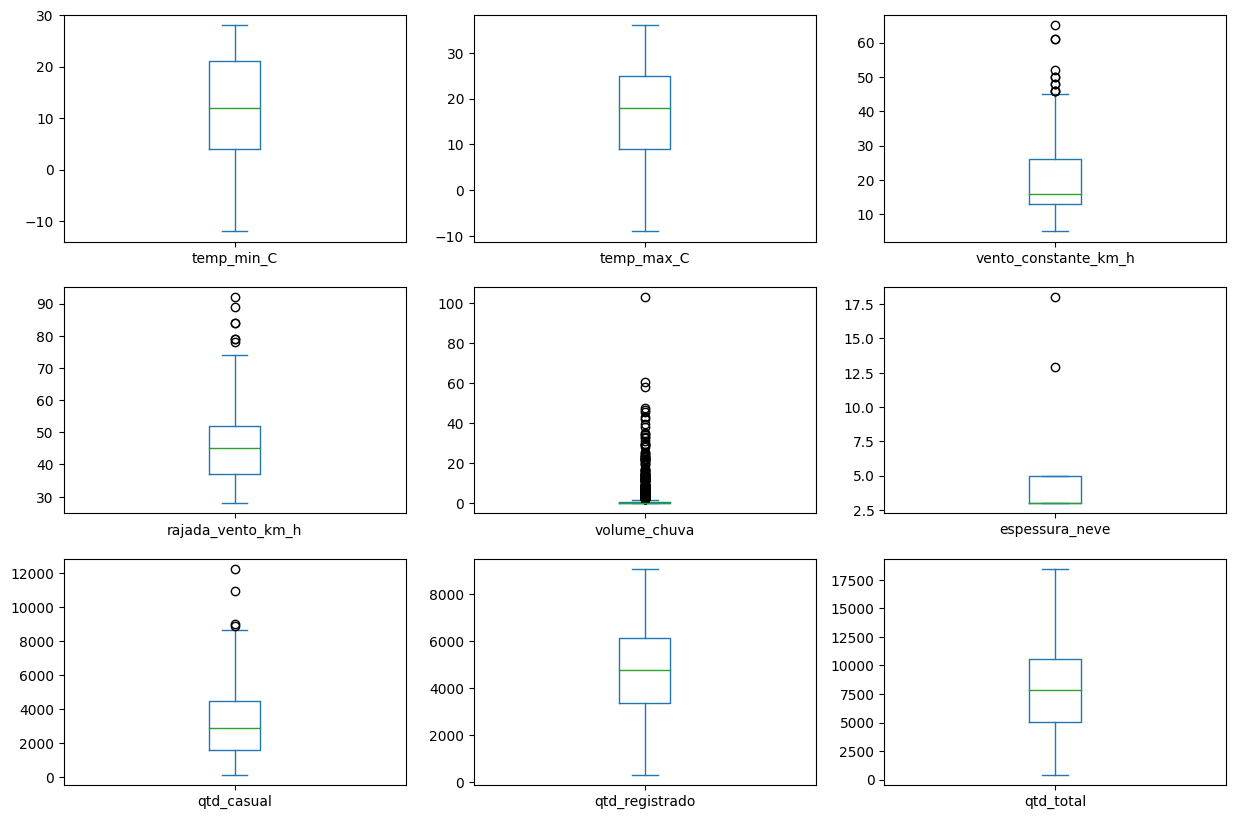

In [30]:
# Boxplot
capital_bike_share.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

#### 3.3 Visualização dos multimodais
No gráfico de correlação a seguir podemos visuzalizar que a quantidade de bicicletas alugadas diminuem com o aumento de volumente de chuva e com a queda da temperatura, no entanto o volume de biciletas alugadas por usuários casuais aumento, se comparado com o volume de chuva (esperavamos o contrário, pois as pessoas não constumam andar de bicicleta na chuva). Entretanto, podemos perceber que quando as condições climáticas de uma maneira geral pioram (vento forte, baixas temperaturas, neve ...) o volume de aluguéis tende a diminuir.

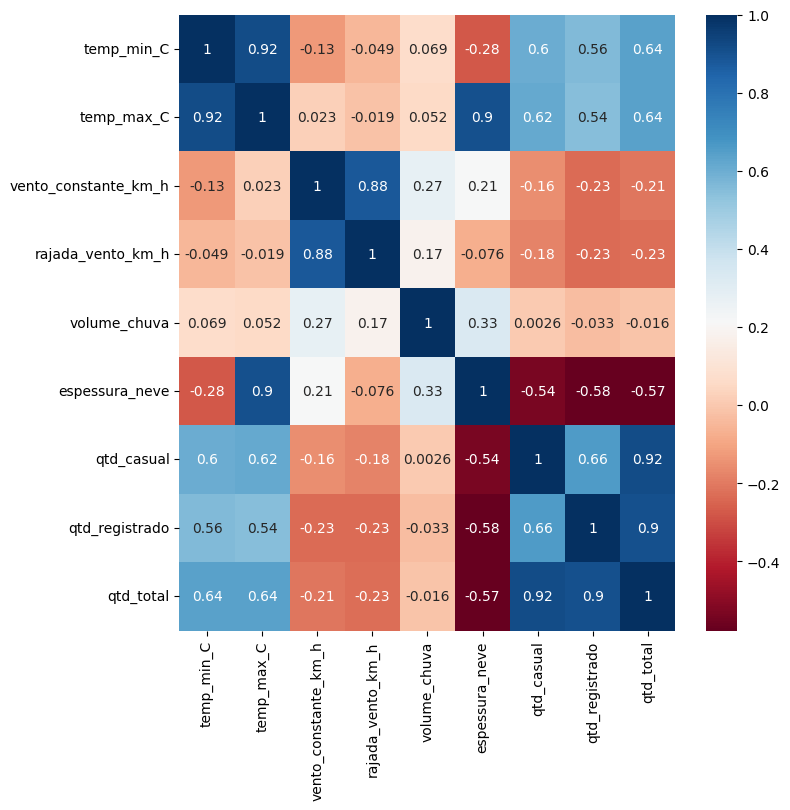

In [31]:
# Matriz de Correlação com Matplotlib Seaborn
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(capital_bike_share.select_dtypes(exclude=['object',bool])\
                                    .corr(), annot=True, cmap='RdBu');

Nos gráficos a seguir,  podemos confirmar que a **quantidade total de aluguéis** aumenta com a **elevação da temperatura**, ou seja, as pessoas tentdem a sair para pedalar em **dias mais quentes**, no entanto os dados mostram que a velocidade do vento constante não influênica o indicador, entrentanto a **rajada de vento fortes tende a diminuir** a procura por bicletas compartilhadas.

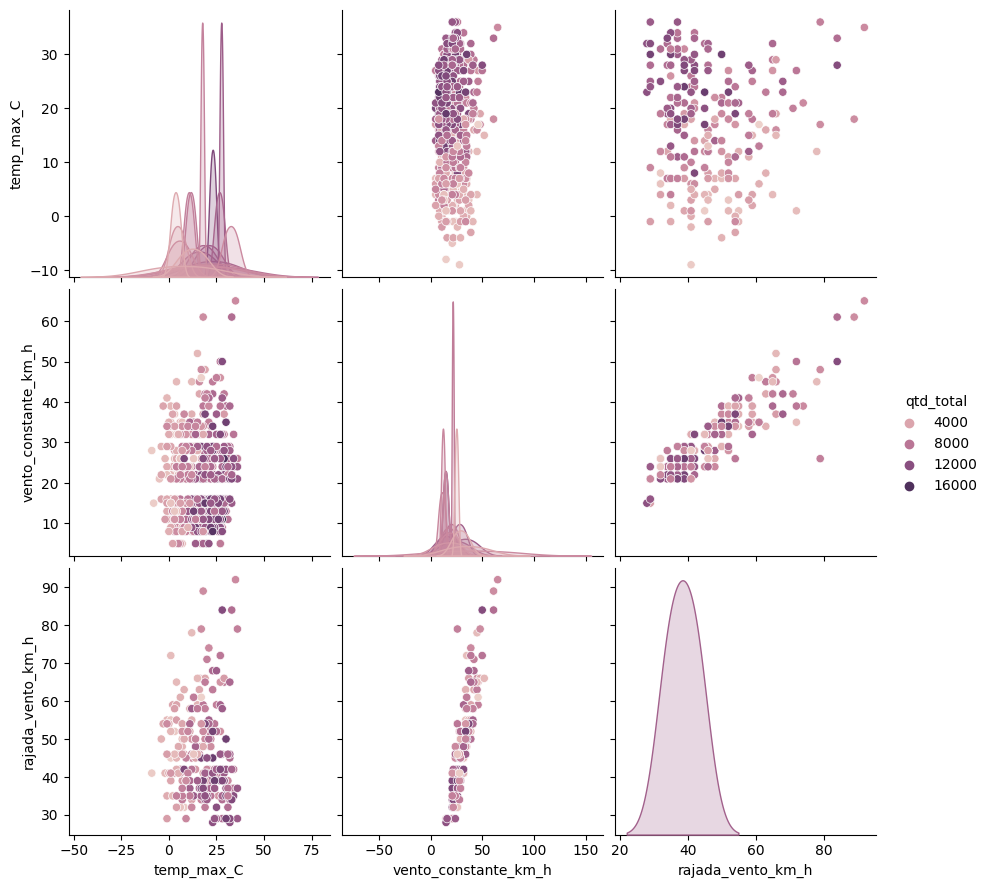

In [32]:
# Visulizar correlação dos dados numéricos
sns.pairplot(capital_bike_share[['temp_max_C','vento_constante_km_h','rajada_vento_km_h','qtd_total']],
            hue = 'qtd_total', height = 3);

#### 3.4 Visualização das quantidades ao longo do tempo

Podemos percerber no gráfico a seguir que o inverno tem a menor demanda por bicicletas, corroborando com os os dados vistos anteriormente, uma vez que quanto pior o evento climático, menor a demanda.

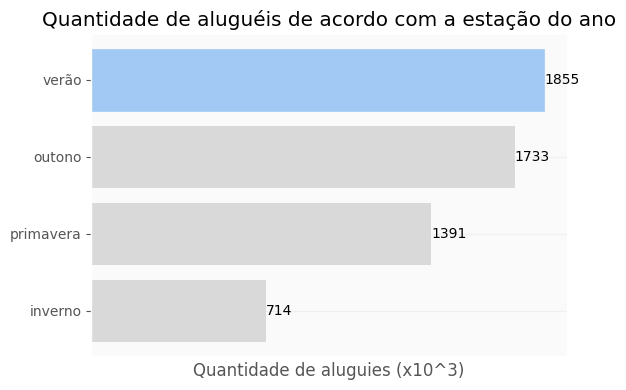

In [48]:
# Crai figura

fig, ax = plt.subplots(figsize=(6,4))

# Calcula total de aluguéis por estação do ano (verão, inverno, primavera e outono)
total_por_estacao_ano = capital_bike_share\
            .groupby(['estacao_ano'])['qtd_total'].sum()\
                                          .reset_index()\
                .sort_values(by='qtd_total',ascending=True)

# Definindo as cores
coreDefault ='#d9d9d9'

# Cria gráfico de barras na horizontal
b = ax.barh(y=total_por_estacao_ano['estacao_ano'],
        width=total_por_estacao_ano['qtd_total']/1e3,
                                color = coreDefault)

# Acrescenta valores a direita das barras
ax.bar_label(ax.containers[0], fmt="%.0f")

# acrescenta um título ao gráfico
plt.title('Quantidade de aluguéis de acordo com a estação do ano')
# Rótulos dos eixos
#plt.ylabel('Esação do ano')
plt.xlabel('Quantidade de aluguies (x10^3)')

# ocultando eixos
plt.xticks([])



# Modifica mais alguns parâmetros gráficos (opciona - questões estéticas)
plt.rc("axes", facecolor="#fafafa",grid=True)
plt.rc("grid", color="#f0f0f0")

# Destanco o maior valor do gráfico
b[-1].set_color('#a1c9f4')


# Ajusta as margens do gráfico (para eliminar margens desnecessárias)
plt.tight_layout()

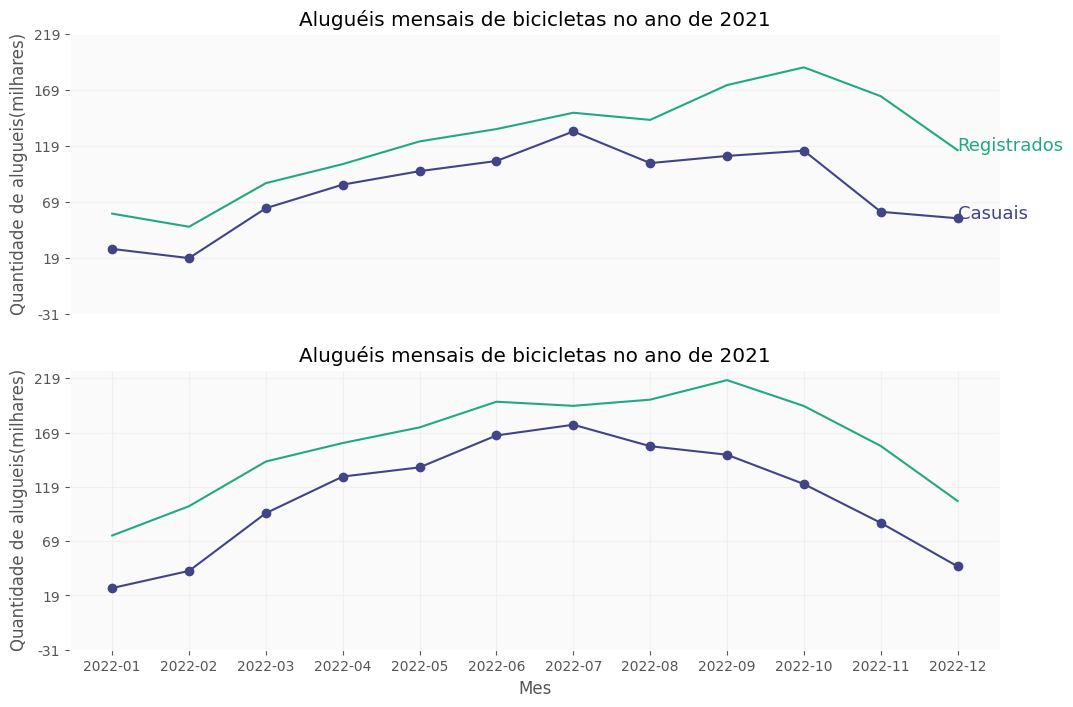

In [34]:
# Total por mês
condicao = capital_bike_share.data.str.contains('2021',na=False)
total_mes = capital_bike_share[['data','qtd_casual','qtd_registrado']]



# Selecionando "ano-mes"
total_mes['data'] = total_mes['data'].str[0:7]

# Conta quantidade por 'ano-mes"
total_mes = total_mes.groupby(['data']).agg({'qtd_casual':'sum',
                                        'qtd_registrado':'sum'})\
                                                  .reset_index()

condicao = total_mes.data.str.contains('2021',na=False)


# prepara a figura (fig) e a área do gráfico (ax) com largura 15 e altura 5
fig, ax = plt.subplots(2, 1, figsize = (12, 8))


# Definindo cores
corExportacao = '#414487'
corImportacao = '#22a884'

# Plota o gráfico de linha
# Note que os dois primeiros parâmetros,
# para os vetores associados aos eixos x e y,
# não devem ser nomeados

# Gráfico do referente a 2021
ax[0].plot(total_mes['data'][condicao],
        total_mes['qtd_casual'][condicao]/1e3,
        color=corExportacao,
        marker='o',
        label='Casuais')

ax[0].plot(total_mes['data'][condicao],
        total_mes['qtd_registrado'][condicao]/1e3,
        color=corImportacao,
        label='Registrados')


# gráfico referente a 2022
ax[1].plot(total_mes['data'][condicao==False],
        total_mes['qtd_casual'][condicao==False]/1e3,
        color=corExportacao,
        marker='o',
        label='Casuais')

ax[1].plot(total_mes['data'][condicao==False],
        total_mes['qtd_registrado'][condicao==False]/1e3,
        color=corImportacao,
        label='Registrados')




# Configurando o layout do primeiro gráfico
# Acrescenta um título ao gráfico
ax[0].set_title('Aluguéis mensais de bicicletas no ano de 2021')
plt.title('Aluguéis mensais de bicicletas no ano de 2021')


# Define os rótulos dos eixos
ax[1].set_xlabel('Mes')
ax[0].set_ylabel('Quantidade de alugueis(milhares)')
ax[1].set_ylabel('Quantidade de alugueis(milhares)')

# Calcula as posições dos valores no eixo Y conforme o intervalo desejado
ymin = round(min((total_mes['qtd_casual']/1e3).tolist()+(total_mes['qtd_registrado']/1e3).tolist())) - 50
ymax = round(max((total_mes['qtd_casual']/1e3).tolist()+(total_mes['qtd_registrado']/1e3).tolist())) + 50

yticks = np.arange(start = ymin, stop = ymax, step = 50)

# Define os valores do eixo y
ax[0].set_yticks(ticks=yticks, labels=["{:.0f}".format(y) for y in yticks])
ax[1].set_yticks(ticks=yticks, labels=["{:.0f}".format(y) for y in yticks])

# Oculta o eixo X do primeiro gráfico
ax[0].set_xticks([])


# Anota o gráfico com os nomes das séries ao final de cada linha
handles = ax[0].get_legend_handles_labels()
for i in range(len(handles)):
  lastx = max(handles[0][i].get_xdata()) # dados X da linha
  lasty = max([handles[0][i].get_ydata()[-1]]) # dados y da linha
  label = handles[1][i]
  ax[0].annotate(text = label, xy = (lastx , lasty),
              color = handles[0][i].get_color(), size=13)

Podemos visualizar a quantidade de locação está ligada com temperaturas mais agradáveis para o passeio de bicicleta, como é o caso da primavera, verão e início do outono. Além disso, podemos perceber que o compartamento do clientes são bem parecidos ao longo dos anos plotados acima.

### 4.Pré-Processamento de dados

#### 4.1 Tratamento dos **missings**

Podemos ver a seguir que  as colunas com das numéricos contém missings, então vamos investigar casos a caso.

In [35]:
# verificando nulls no dataset
capital_bike_share.isnull().sum()

data                      0
ano                       0
mes                       0
feriado                   0
dia_util                  0
descricao_clima           0
temp_min_C                1
temp_max_C                1
vento_constante_km_h     56
rajada_vento_km_h       500
volume_chuva              4
espessura_neve          714
estacao_ano               0
qtd_casual                0
qtd_registrado            0
qtd_total                 0
dtype: int64

Visualização gráfica.

<Axes: >

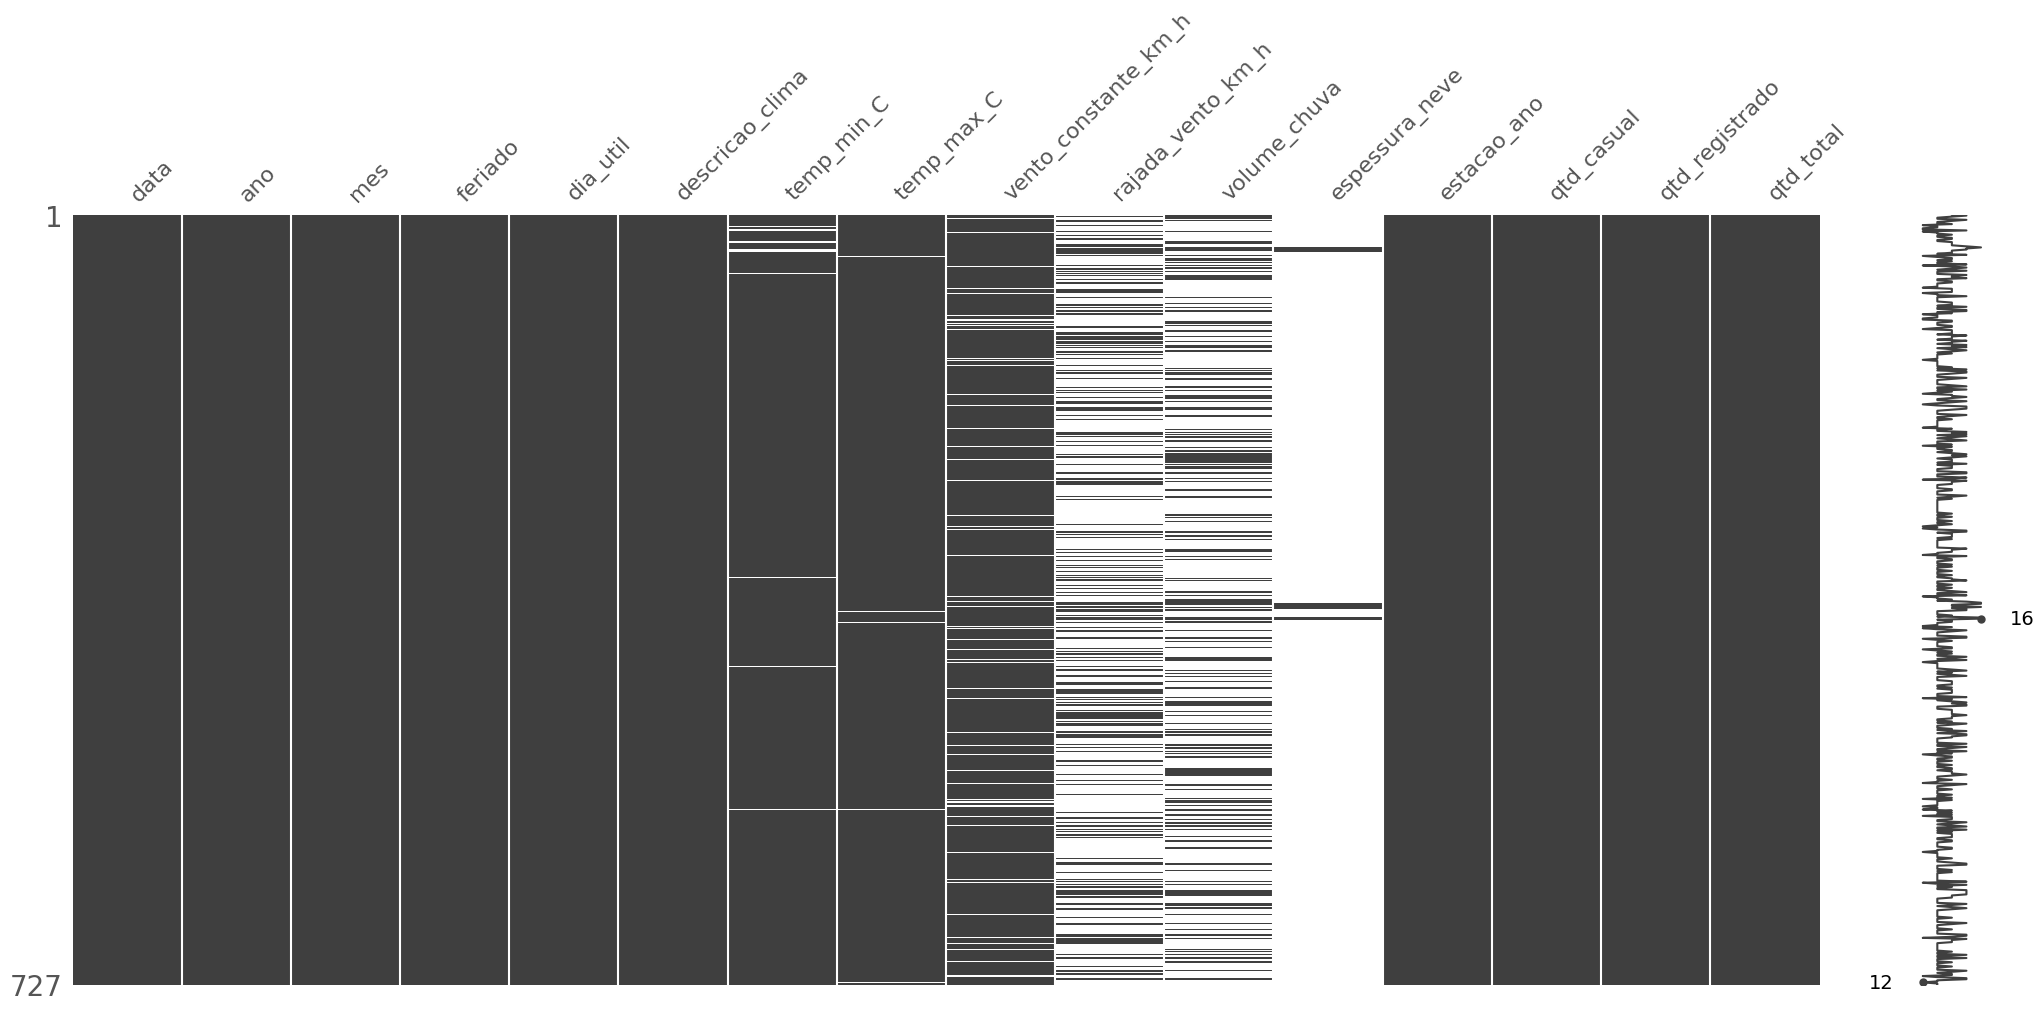

In [36]:
# recuperando os nomes das colunas
col = list(capital_bike_share.columns)

# o novo dataset irá conter todas as colunas do dataset original
dataset_sem_missings= capital_bike_share[col[:]]

# substituindo os zeros por NaN
dataset_sem_missings.replace(0, np.nan, inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(dataset_sem_missings)

Para tratar o missing da ** "temp_min_C"** e **"temp_max_C"**, vamos preencher os valores com a média entre a temperatura do dia anterior e do dia seguinte, ao dia 2022-07-17

In [37]:
#Visualizando
display(capital_bike_share[capital_bike_share.temp_min_C.isna()])

# ordernando o dataset pela data e refazendo o index
## para ter certeza que pegaremos as datas corretas
capital_bike_share.sort_values(by='data',inplace=True)
capital_bike_share.reset_index(drop=True,inplace=True)


# Preechendo o missing
capital_bike_share.loc[561, 'temp_min_C'] = (capital_bike_share.loc[560, 'temp_min_C']+\
                                              capital_bike_share.loc[562, 'temp_min_C'])/2

capital_bike_share.loc[561, 'temp_max_C'] = (capital_bike_share.loc[560, 'temp_max_C']+\
                                              capital_bike_share.loc[562, 'temp_max_C'])/2

,data,ano,mes,feriado,dia_util,descricao_clima,temp_min_C,temp_max_C,vento_constante_km_h,rajada_vento_km_h,volume_chuva,espessura_neve,estacao_ano,qtd_casual,qtd_registrado,qtd_total
561,2022-07-17,2022,07,False,False,Chuva,NaN,NaN,13.0,NaN,35.0,NaN,verão,6657,5637,12294


Para os casos de ventos contantes, volume de chuva e espessura de neve, iremos substituir por 0, pois faz sentido não termos vento, chuva ou neve em um determinado dia.

In [38]:
# Selecionando e substituindo por ZERO

# Ventos constantes
condicao = capital_bike_share['vento_constante_km_h'].isna()
capital_bike_share.loc[condicao, 'vento_constante_km_h'] = 0

# Chuva
condicao = capital_bike_share['volume_chuva'].isna()
capital_bike_share.loc[condicao, 'volume_chuva'] = 0

# Espessura da neve
condicao = capital_bike_share['espessura_neve'].isna()
capital_bike_share.loc[condicao, 'espessura_neve'] = 0

Para a coluna de rajadas de ventos, caso a coluna seja vazia, vamos substituir com os dados da velocidade constantes do vento, tomando como raciocício que o vento pode viajar com velocidade constante ou ter momentos de aceleração (atingindo uma velocidade máxima, ou rajada de vento).

In [39]:
# Substituindo os missing da rajada_vento com os valores
## das velocidades constantes
condicao = capital_bike_share['rajada_vento_km_h'].isna()
capital_bike_share.loc[condicao, 'rajada_vento_km_h'] = \
    capital_bike_share.loc[condicao, 'vento_constante_km_h']

Na visualização após o tratamento, podemos perceber que o datasetr n**ão contém mais valores "missings"**


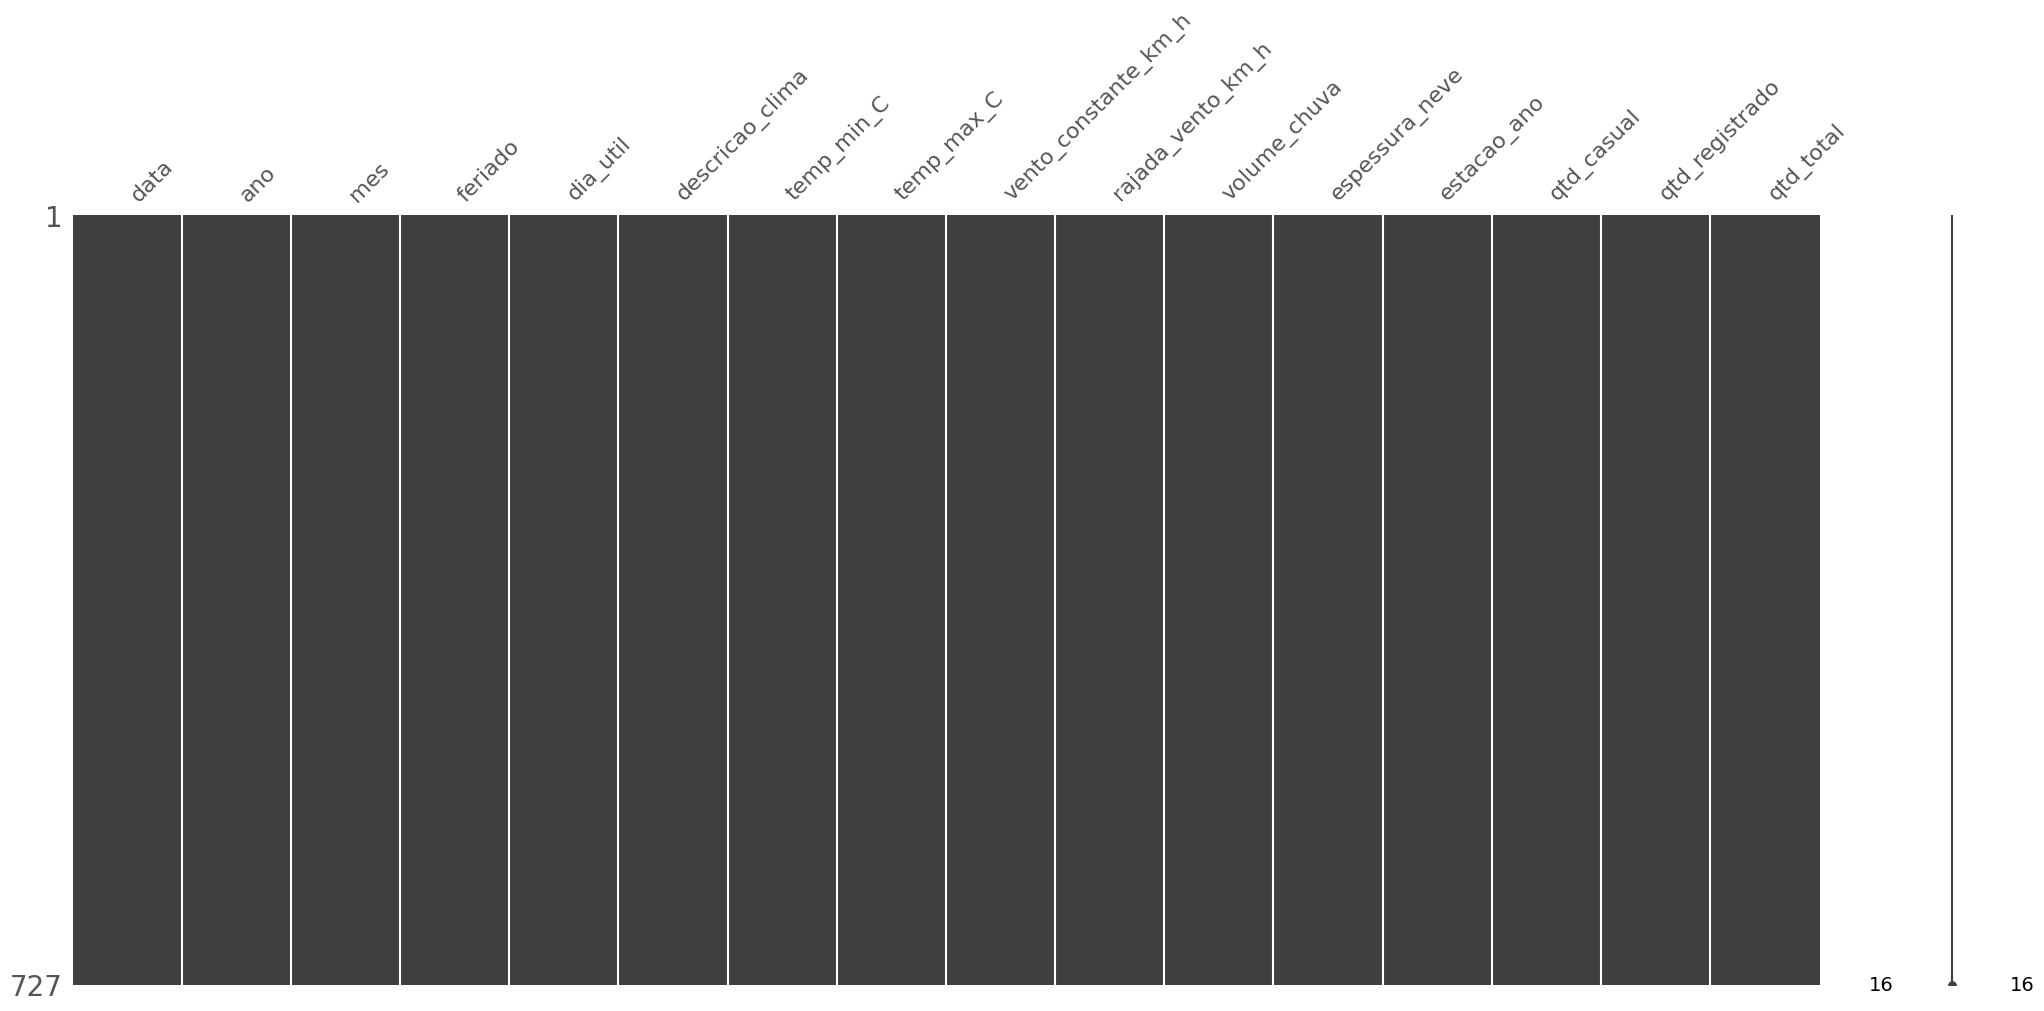

In [40]:
# recuperando os nomes das colunas
col = list(capital_bike_share.columns)

# o novo dataset irá conter todas as colunas do dataset original
dataset_sem_missings= capital_bike_share[col[:]]

# exibindo visualização matricial da nulidade do dataset
ms.matrix(dataset_sem_missings);

Agora que tratamos os missings, vale olhar novamente a variação das quantidades de "aluguéis" em relação aos finaais de semana e feriados, assim como as condições climáticas novamente.

Visualizando as méidas das quantidades de aluguéis de bicicletas alugadas no feriado e finais de semana, são parecidas com as médias dos dias útueis.

In [41]:
capital_bike_share.groupby(['dia_util'])['qtd_total']\
                                .mean().reset_index()\
   .rename(columns={'qtd_total':'média_da_quantidade'})

,dia_util,média_da_quantidade
0,False,7730.57265
1,True,7850.27541


Plotando a variação das quantidades de aluguéis, podemos perceber que o aumento da temperatura acarreta um aumento, ventos mas fracos, um baixo volume de chuva e ausência de neve, estão ligados ao aumento do número de locação.

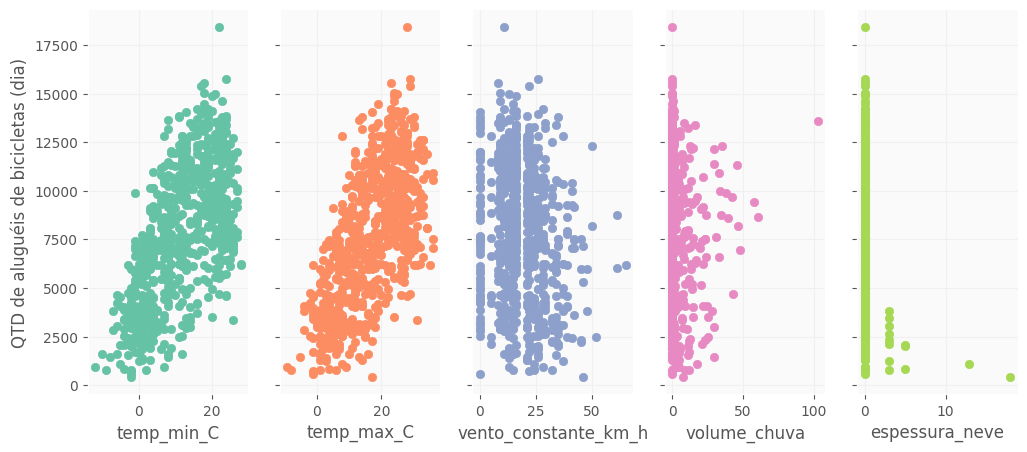

In [42]:
# Colunas que serão plotadas versuas a quantidade de bicicletas alugadas
colunas = ['temp_min_C', 'temp_max_C', 'vento_constante_km_h',
           'volume_chuva', 'espessura_neve']

# Definindo as cores
lista_color = sns.color_palette("Set2", len(colunas))


fig, ax = plt.subplots(nrows=1, ncols= 5,
                         figsize = (12,5),
                         sharey = 'row')

for i in range(len(colunas)):
   ax[i].scatter(capital_bike_share[colunas[i]],
                 capital_bike_share['qtd_total'],
                  c=lista_color[i] );
   ax[i].set_xlabel(colunas[i])
   if i == 0:
      ax[i].set_ylabel('QTD de aluguéis de bicicletas (dia)')

#### 4.2. Separação do conjunto de treino e conjunto de teste

Como o objetivo deste trabalho é preparar uma base de dados para previsão de bicicletas que serão aludas por dia, levando em consideração os eventos climáticos, iremos separa em uma **base para treino** e outra para **teste**, que serão aplicados ao código de **aprendizado de máquina** que utiliza **regressão** no seu treinamento.

Vale ressaltar, que é aconselhavel separarmos os dados de entrada (rotulados) em dois subconjuntos: o de treinamento, utilizado na produção do modelo, e o conjunto de teste (conhecido como conjunto de validação), com o objetivo de identificarmos como o modelo ir´se comportar com não não visto (Notas de aula, Introdução e aplicações de ciência de dados, Puc-Rio)

In [43]:
# Copiando o dataset original
dataset_treino = capital_bike_share.copy()

# Separando os valores do dataset em componentes de input (X) e output (Y)
X = dataset_treino.values[:,0:15]
Y = dataset_treino.values[:,15]

In [44]:
# Separando a base de treino com 80% dos dados
test_size = 1/5
seed = 8

X_train, X_test, y_train, y_test = train_test_split(X, Y,
    test_size=test_size, shuffle=True, random_state=seed) # sem estratificação

### 5. Conclusão

  Atualmente a grande maioria das pessoas que gostam dados, tem vontade de trabalhar na parte de aprendizado de máquinas, no entanto, ao longo do desenvolvimento deste MVP, ficou muito clara que a parte mais onerosa é a captura e tratamento do dados reais, a etapa 2 de um projeto de ciência de dados.
  
  Na etapa de coleta e análise de dados, citado anteriormente, temos muitos dados faltantes, pontos muito longe da média ou mediana (os outliers) e o mais complicado na minha opinião, os dados sem padrão. Isso gera muito trabalho de entendimento dos dados e para criação dos padrões (criação de claases). É importante ressaltar, que podemos até piorar a base de dados, se não tivermos um entendimento do que os dados estão dizendo e o problema que desejamos resolver.


  Dito isso, fica muito claro a importância da definição do problema que desajamos resolver, a captura e análise dos dados e a etapa de pré-processamento, para um modelo de aprendizado de máquina, pois se os dados são "poluídos", o modelo retorna tende a retorna previsões incorretas gerando mais problemas do que solução para o cliente.        